<a href="https://colab.research.google.com/github/blankazselyke/DL_NHF/blob/main/DL_NHF_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/blankazselyke/DL_NHF/blob/main/DL_NHF.ipynb)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab import userdata
import tensorflow as tf
import os
import cv2
from tensorflow.keras import layers, models, losses, optimizers, metrics
import tensorflow.keras.backend as K
from PIL import Image


In [2]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [3]:
# Download data
!kaggle competitions download -c airbus-ship-detection

100% 28.6G/28.6G [25:02<00:00, 21.2MB/s]
100% 28.6G/28.6G [25:02<00:00, 20.4MB/s]


In [4]:
# Unzip data
!unzip airbus-ship-detection.zip

A streamkimeneten csak az utolsó 5000 sor látható.
  inflating: train_v2/f9775b70e.jpg  
  inflating: train_v2/f977a470c.jpg  
  inflating: train_v2/f9780bfaf.jpg  
  inflating: train_v2/f9782bdfe.jpg  
  inflating: train_v2/f9785ca49.jpg  
  inflating: train_v2/f9785e462.jpg  
  inflating: train_v2/f97a719d5.jpg  
  inflating: train_v2/f97afa376.jpg  
  inflating: train_v2/f97b85e3e.jpg  
  inflating: train_v2/f97bd0b11.jpg  
  inflating: train_v2/f97bd6b80.jpg  
  inflating: train_v2/f97bfb1b2.jpg  
  inflating: train_v2/f97c8cbbe.jpg  
  inflating: train_v2/f97cdd397.jpg  
  inflating: train_v2/f97d92e1e.jpg  
  inflating: train_v2/f97da9e70.jpg  
  inflating: train_v2/f97e843d3.jpg  
  inflating: train_v2/f97e961f2.jpg  
  inflating: train_v2/f97e96c68.jpg  
  inflating: train_v2/f97f63ae1.jpg  
  inflating: train_v2/f97f80839.jpg  
  inflating: train_v2/f97f83438.jpg  
  inflating: train_v2/f97fab9ad.jpg  
  inflating: train_v2/f97fd4915.jpg  
  inflating: train_v2/f9801bc03.jpg  

In [ ]:
!rm /content/airbus-ship-detection.zip

In [7]:
file_path = "/content/train_ship_segmentations_v2.csv" # Set the file path
data = pd.read_csv(file_path) # Read the CSV file
print(data.head()) # Display the first few rows of the data

         ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


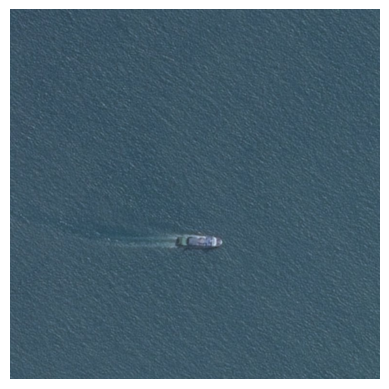

Displaying image 000155de5.jpg


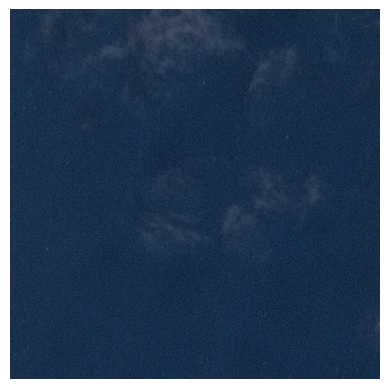

Displaying image 00003e153.jpg


In [8]:
# Diplaying an image
def display_image(image_name):
    img = plt.imread(f'/content/train_v2/{image_name}')
    plt.imshow(img)
    plt.axis('off')
    plt.show()
    print("Displaying image " + image_name)

image_with_ship = data['ImageId'][2]
image_without_ship = data['ImageId'][0]
display_image(image_with_ship)
display_image(image_without_ship)

In [9]:
# Function for converting rle masks to binary masks
def rle_decode(mask_rle, shape=(768, 768)):
    if pd.isna(mask_rle):
        return np.zeros((shape[0], shape[1]), dtype=np.uint8)

    s = mask_rle.split() # Split the mask_rle string by spaces to separate start and length values
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])] # Convert the start and length values to integer arrays
    starts -= 1 # Adjust start values to zero-based indexing
    ends = starts + lengths # Calculate end positions by adding start and length values
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8) # Create a flat image array filled with zeros

    for start, end in zip(starts, ends): # Set pixels between start and end positions to 1 for each segment
        img[start:end] = 1

    return img.reshape(shape).T # Reshape the flat array to the given shape and transpose it

In [10]:
# Sample for decoding, decode the image with ship
sample_mask_rle = data[data['ImageId'] == image_with_ship]['EncodedPixels'].iloc[0]
sample_mask_decoded = rle_decode(sample_mask_rle)

print(f" Original sample_mask_rle: {sample_mask_rle}")
print(f" Binary sample_mask_decoded: {sample_mask_decoded}")
num_ones = np.sum(sample_mask_decoded == 1)
print("Number of 1's in the mask:", num_ones)

 Original sample_mask_rle: 264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 272341 33 273109 33 273877 33 274645 33 275413 33 276181 33 276949 33 277716 34 278484 34 279252 33 280020 33 280788 33 281556 33 282324 33 283092 33 283860 33 284628 33 285396 33 286164 33 286932 33 287700 33 288468 33 289236 33 290004 33 290772 33 291540 33 292308 33 293076 33 293844 33 294612 33 295380 33 296148 33 296916 33 297684 33 298452 33 299220 33 299988 33 300756 33 301524 33 302292 33 303060 33 303827 34 304595 34 305363 33 306131 33 306899 33 307667 33 308435 33 309203 33 309971 33 310739 33 311507 33 312275 33 313043 33 313811 33 314579 33 315347 33 316115 33 316883 33 317651 33 318419 33 319187 33 319955 33 320723 33 321491 33 322259 33 323027 33 323795 33 324563 33 325331 33 326099 33 326867 33 327635 33 328403 33 329171 33 329938 34 330706 34 331474 33 332242 33 333010 33 333778 33 334546 33 335314 33 336082 33 336850 33 337618 33 338386 33 339

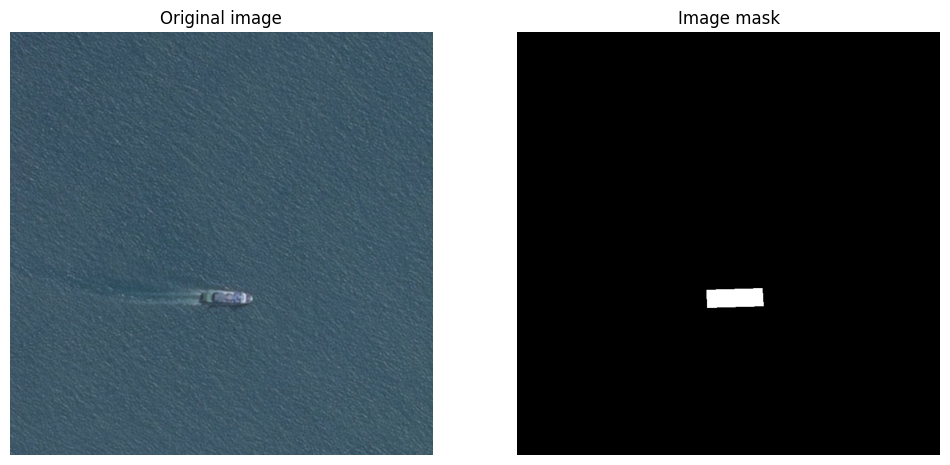

In [11]:
# Visualizing the mask
def display_image_with_mask(image_name, mask_rle):
    img = plt.imread(f'/content/train_v2/{image_name}')
    mask = rle_decode(mask_rle)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Original image')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.title('Image mask')
    plt.show()

display_image_with_mask(image_with_ship, sample_mask_rle)

In [12]:
image_directory = '/content/train_v2/'

# When there are multiple ships, multiple masks belong to one image, so we gather the unique ids
ids = np.unique(data['ImageId'])
image_paths = [os.path.join(image_directory, img_id) for img_id in ids]

# Image loading
def load_image(img_id):
    image = tf.io.read_file(img_id)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, (768, 768))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    return image

# Create dataset
image_dataset = tf.data.Dataset.list_files(image_paths, shuffle=False)
image_dataset = image_dataset.map(lambda x: load_image(x))
image_dataset = image_dataset.batch(8)  # Batch size
image_dataset = image_dataset.prefetch(tf.data.AUTOTUNE)  # Prefetch optimalization

In [ ]:
#import shutil
#shutil.rmtree("/content/train_masks")

In [13]:
mask_directory = '/content/train_masks/'
os.makedirs(mask_directory, exist_ok=True)

def save_mask(row):
    img_id = row['ImageId']  # Get the image ID from the DataFrame row
    encoded_pixels = row['EncodedPixels']  # Get the RLE mask for this row

    # Decode the RLE mask if it's not NaN
    if pd.notna(encoded_pixels):
        decoded_mask = rle_decode(encoded_pixels)
    else:
        # If there is no mask for this image, create an empty mask
        decoded_mask = np.zeros((768, 768), dtype=np.uint8)
        decoded_mask = (decoded_mask * 255).astype(np.uint8)

    # Define the mask file path
    mask_path = os.path.join(mask_directory, f'{img_id}')

     # Check if the mask file already exists
    if os.path.exists(mask_path):
        # If it exists, load the existing mask
        existing_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Merge the existing mask and the new mask using np.maximum
        combined_mask = np.maximum((decoded_mask * 255).astype(np.uint8), existing_mask)

    else:
        # If the file doesn't exist, use the new mask as-is
        combined_mask = decoded_mask

    # Save the combined mask to the directory
    cv2.imwrite(mask_path, combined_mask)

# Iterate through the rows of the DataFrame
for _, row in data.iterrows():
    save_mask(row)

def load_mask(img_id):
    image = tf.io.read_file(img_id)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, (768, 768))
    image = tf.cast(image, tf.float32) / 255.0  # Normalize
    return image

In [14]:
# Create dataset for masks
mask_dataset = tf.data.Dataset.list_files([os.path.join(mask_directory, f'{img_id}') for img_id in data['ImageId'].unique()], shuffle=False)
mask_dataset = mask_dataset.map(lambda x: load_mask(x))
mask_dataset = mask_dataset.batch(8)  # Batch size
mask_dataset = mask_dataset.prefetch(tf.data.AUTOTUNE)  # Prefetch optimization

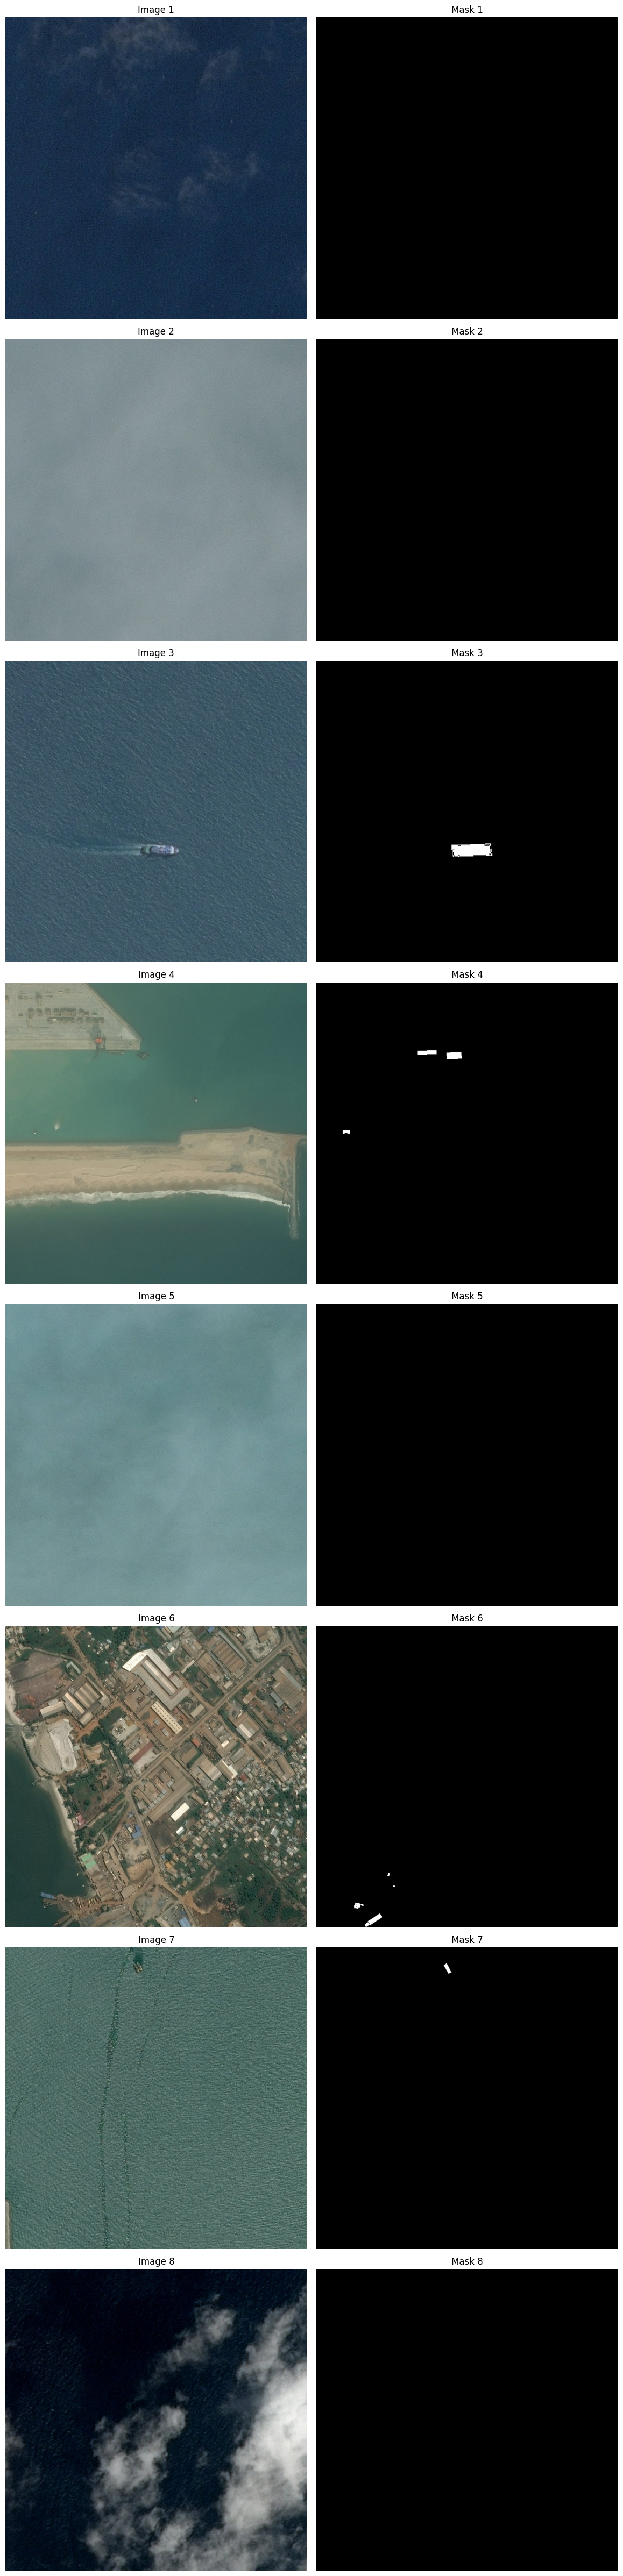

In [15]:
# Visualize combined masks
num_images_to_display = 8
fig, axes = plt.subplots(num_images_to_display, 2, figsize=(12, 6 * num_images_to_display))

X = image_dataset.take(1).as_numpy_iterator().next()
Y = mask_dataset.take(1).as_numpy_iterator().next()

for i in range(num_images_to_display):
    axes[i, 0].imshow(X[i], cmap='gray')
    axes[i, 0].set_title(f'Image {i + 1}')
    axes[i, 0].axis('off')

    axes[i, 1].imshow(Y[i], cmap='gray')
    axes[i, 1].set_title(f'Mask {i + 1}')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [16]:
# Prepare the dataset for training

# Train: 80%
# Test : 10%
# Validation: 10%

dataset = tf.data.Dataset.zip((image_dataset, mask_dataset))

total_size = len(dataset)
train_count = int(total_size * 0.8)
val_count = int(total_size * 0.1)

train_dataset = dataset.take(train_count)
remaining_dataset = dataset.skip(train_count)

val_dataset = remaining_dataset.take(val_count)
test_dataset = remaining_dataset.skip(val_count)

In [17]:
# Check if the split was correct

print(f'Train batches: {len(train_dataset)}')
print(f'Validation batches: {len(val_dataset)}')
print(f'Test batches: {len(test_dataset)}')
for image_batch, mask_batch in train_dataset.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Mask batch shape:", mask_batch.shape)

Train batches: 19256
Validation batches: 2407
Test batches: 2407
Image batch shape: (8, 768, 768, 3)
Mask batch shape: (8, 768, 768, 1)


In [20]:
def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def build_model(input_shape=(768, 768, 3)):
    inputs = layers.Input(input_shape)

    # Downsampling path (encoder)
    c1 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.MaxPooling2D((2, 2))(c1)
    c2 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    c2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(c2)

    # Upsampling path (decoder)
    u1 = layers.UpSampling2D((2, 2))(c3)
    u1 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(u1)
    u2 = layers.UpSampling2D((2, 2))(u1)
    u2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u2)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(u2)

    model = models.Model(inputs, outputs)
    return model

# Build and compile the model
model = build_model()
model.compile(optimizer="adam",
              loss=dice_loss,
              metrics= [metrics.MeanIoU(num_classes=2)])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 768, 768, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 768, 768, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 384, 384, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 384, 384, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 192, 192, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 192, 192, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_4 (UpSampling2D)       │ (None, 384, 384, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 384, 384, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_5 (UpSampling2D)       │ (None, 768, 768, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 768, 768, 16)        │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 768, 768, 1)         │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 28,225 (110.25 KB)

 Trainable params: 28,225 (110.25 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# For Demo and speed purposes, use 1/32nds of data

In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_count//4096,
    validation_data=val_dataset,
    validation_steps=val_count//2048,
    epochs=1,
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.9992 - mean_io_u_2: 0.4998

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
import matplotlib.pyplot as plt

# Take one batch from the test dataset
for image_batch, mask_batch in test_dataset.take(1):
    predictions = model.predict(image_batch)

    # Display a few images with their masks and predictions
    for i in range(3):
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 3, 1)
        plt.title("Original Image")
        plt.imshow(tf.keras.utils.array_to_img(image_batch[i]))

        plt.subplot(1, 3, 2)
        plt.title("True Mask")
        plt.imshow(mask_batch[i, :, :, 0], cmap='gray')

        plt.subplot(1, 3, 3)
        plt.title("Predicted Mask")
        plt.imshow(predictions[i, :, :, 0], cmap='gray')

        plt.show()